<center><big><b>SegPore for m6A identification</b></big></center>

For m6A, we train the 5mer parameter table on three wild type samples of HEK293T cells, and test on wild type mouse embryonic stem cells (mESCs).

The ground truth and label of the training data are avaible from xPore (Pratanwanich, P.N. et al. Identification of differential RNA modifications from nanopore direct RNA sequencing with xPore. Nat Biotechnol 39, 1394-1402, 2021, Supplementary Data 1). First, we select 5mers with significant modifications if its read coverage is greater than 1500. After we run SegPore workflow, we only keep the 5mers with the 
distance between two component means in the GMM is greater than 5. For testing data, the annotated m6A genomic locations are obtained by taking the union of MeRIP-seq, miCLIP, and miCLIP2.

In [1]:
import os, csv, math
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

xpore_kmer_df = pd.read_csv("xpore_kmer_stat.csv").sort_values(by='position_num', ascending=False)
mes_kmer_df = pd.read_csv("mes_kmer_stat.csv").sort_values(by='position_num', ascending=False)

common_kmer = intersection(list(xpore_kmer_df['kmer']), list(mes_kmer_df['kmer']))

xpore_kmer = list(xpore_kmer_df['kmer'])
xpore_pos_num = list(xpore_kmer_df['position_num'])
xpore_title =  "Human HEK293T m6A modification motifs (training data)"

mes_kmer = list(mes_kmer_df['kmer'])
mes_pos_num = list(mes_kmer_df['position_num'])
mes_title = "Mouse embryonic stem (mESCs) m6A modification motifs (testing data)"

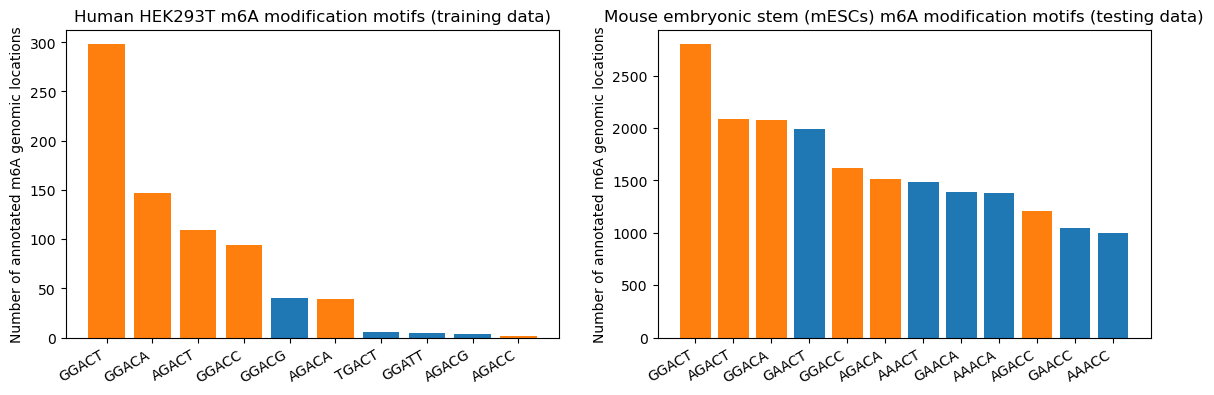

Common 5mers :  ['GGACC', 'GGACT', 'GGACA', 'AGACT', 'AGACA', 'AGACC']


In [2]:
plt.figure(figsize=(14, 4))

ax1 = plt.subplot(1, 2, 1)
bar_colors_ax1 = []
bar_labels_ax1 = []
for kmer in xpore_kmer:
    if kmer in common_kmer:
        bar_colors_ax1.append('tab:orange')
        bar_labels_ax1.append("c")
    else:
        bar_colors_ax1.append('tab:blue')
        bar_labels_ax1.append("u")

ax1.bar(xpore_kmer, xpore_pos_num, color=bar_colors_ax1)
ax1.set_xticks(xpore_kmer, xpore_kmer, rotation=30, ha='right')
ax1.set_ylabel('Number of annotated m6A genomic locations')
ax1.set_title(xpore_title)

ax2 = plt.subplot(1, 2, 2)
bar_colors_ax2 = []
bar_labels_ax2 = []
for kmer in mes_kmer:
    if kmer in common_kmer:
        bar_colors_ax2.append('tab:orange')
        bar_labels_ax2.append("c")
    else:
        bar_colors_ax2.append('tab:blue')
        bar_labels_ax2.append("u")

ax2.bar(mes_kmer, mes_pos_num, color=bar_colors_ax2)
ax2.set_xticks(mes_kmer, mes_kmer, rotation=30, ha='right')
ax2.set_ylabel('Number of annotated m6A genomic locations')
ax2.set_title(mes_title)

plt.show()

print('Common 5mers : ', common_kmer)

In [3]:
model_kmer = pd.read_csv("model_kmer_m6A.csv")
model_kmer_select = model_kmer[model_kmer['select'] == 1]
print(model_kmer_select)

    model_kmer  model_mean  model_stdv  model_mean_mod  model_stdv_mod  \
132      AGACA      125.56        3.26          117.98            2.39   
133      AGACC      125.60        3.29          119.34            2.03   
135      AGACT      129.81        3.34          124.24            2.61   
644      GGACA      118.40        3.76          111.81            2.80   
645      GGACC      119.23        3.77          112.87            2.49   
647      GGACT      123.83        3.01          117.79            2.87   

     select  differ  
132       1    7.58  
133       1    6.26  
135       1    5.57  
644       1    6.59  
645       1    6.36  
647       1    6.04  


In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
round_n = 3
gt = "miCLIP2"  


def compute_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def compute_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def plot_roc_auc(model_df, mode, title):
    plt.figure(dpi=500)
    if mode == "all":
        to_compare = ["SegPore+m6Anet", "Nanopolish+m6Anet", "CHEUI",  "Epinano", "Nanom6A", "MINES", "Tombo"]
    else:
        to_compare = ["SegPore+m6Anet", "Nanopolish+m6Anet", "CHEUI",  "SegPore", "Epinano", "Nanom6A", "MINES", "Tombo"]
    
    model_df = model_df[to_compare + [gt]].dropna()
    for col in to_compare:
        y_true, y_pred = model_df[gt].values, model_df[col].values
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = round(auc(fpr, tpr), round_n)
        if col == 'SegPore':
            plt.plot(fpr, tpr, label=col + "(AUC=" + str(roc_auc) + ")", linewidth=2.0, color="black")
        elif mode == "selected" and col == 'Nanopolish+m6Anet':
            col = "m6Anet"
            plt.plot(fpr, tpr, label=col + "(AUC=" + str(roc_auc) + ")", linewidth=1.0)
        elif mode == "selected" and col == 'SegPore+m6Anet':
            continue
        else:
            plt.plot(fpr, tpr, label=col + "(AUC=" + str(roc_auc) + ")", linewidth=1.0)
            

    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()
    x = np.linspace(0, 1)
    plt.plot(x, x, ls="-.", linewidth=0.5, color="gray")
    plt.title("ROC AUC")
    #plt.show()
    plt.savefig(title)
    
    
def plot_pr_auc(model_df, mode, title):
    plt.figure(dpi=500)
    if mode == "all":
        to_compare = ["SegPore+m6Anet", "Nanopolish+m6Anet", "CHEUI", "Epinano", "Nanom6A", "MINES", "Tombo"]
    else:
        to_compare = ["SegPore+m6Anet", "Nanopolish+m6Anet", "CHEUI",  "SegPore", "Epinano", "Nanom6A", "MINES", "Tombo"]
    model_df = model_df[to_compare + [gt]].dropna()
    for col in to_compare:
        y_true, y_pred = model_df[gt].values, model_df[col].values
        precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
        pr_auc = round(auc(recall, precision), round_n)
        if col == 'SegPore':
            plt.plot(recall, precision, label=col + "(AUC=" + str(pr_auc) + ")", linewidth=2.0, color="black")
        elif mode == "selected" and col == 'Nanopolish+m6Anet':
            col = "m6Anet"
            plt.plot(recall, precision, label=col + "(AUC=" + str(pr_auc) + ")", linewidth=1.0)
        elif mode == "selected" and col == 'SegPore+m6Anet':
            continue
        else:
            plt.plot(recall, precision, label=col + "(AUC=" + str(pr_auc) + ")", linewidth=1.0)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    x = np.linspace(0, 1)
    plt.title("PR AUC")
    plt.savefig(title)

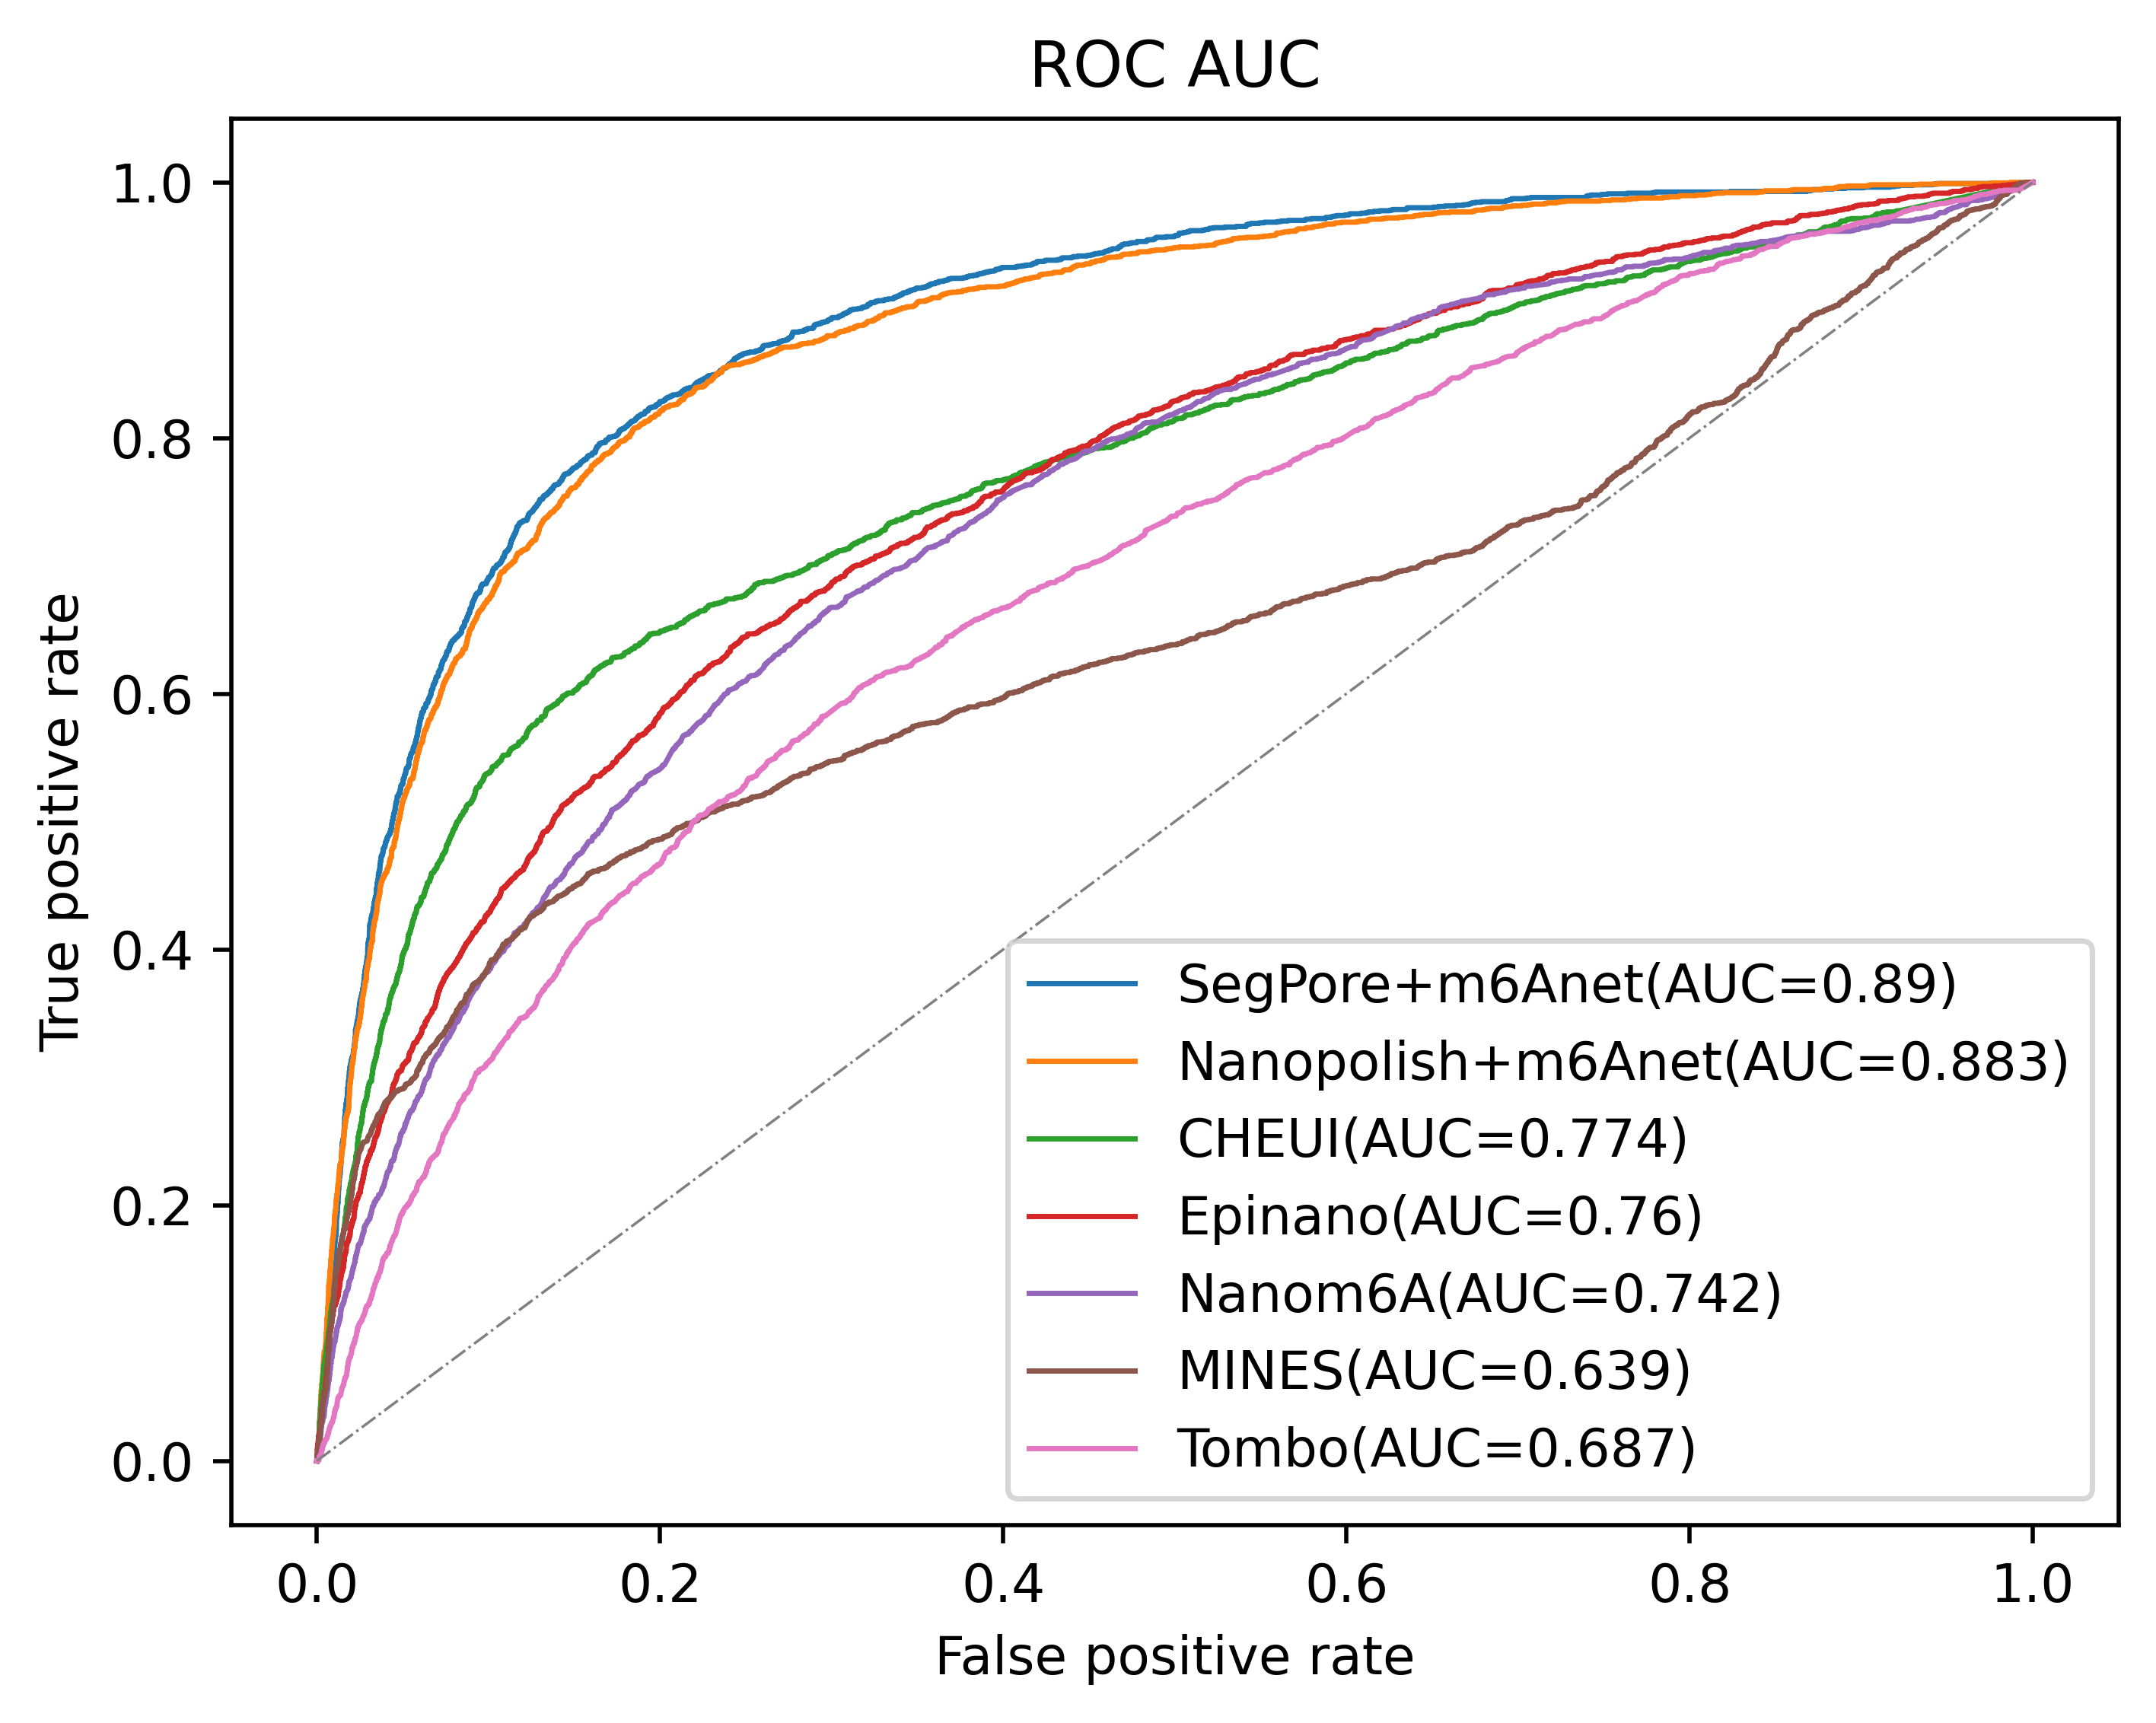

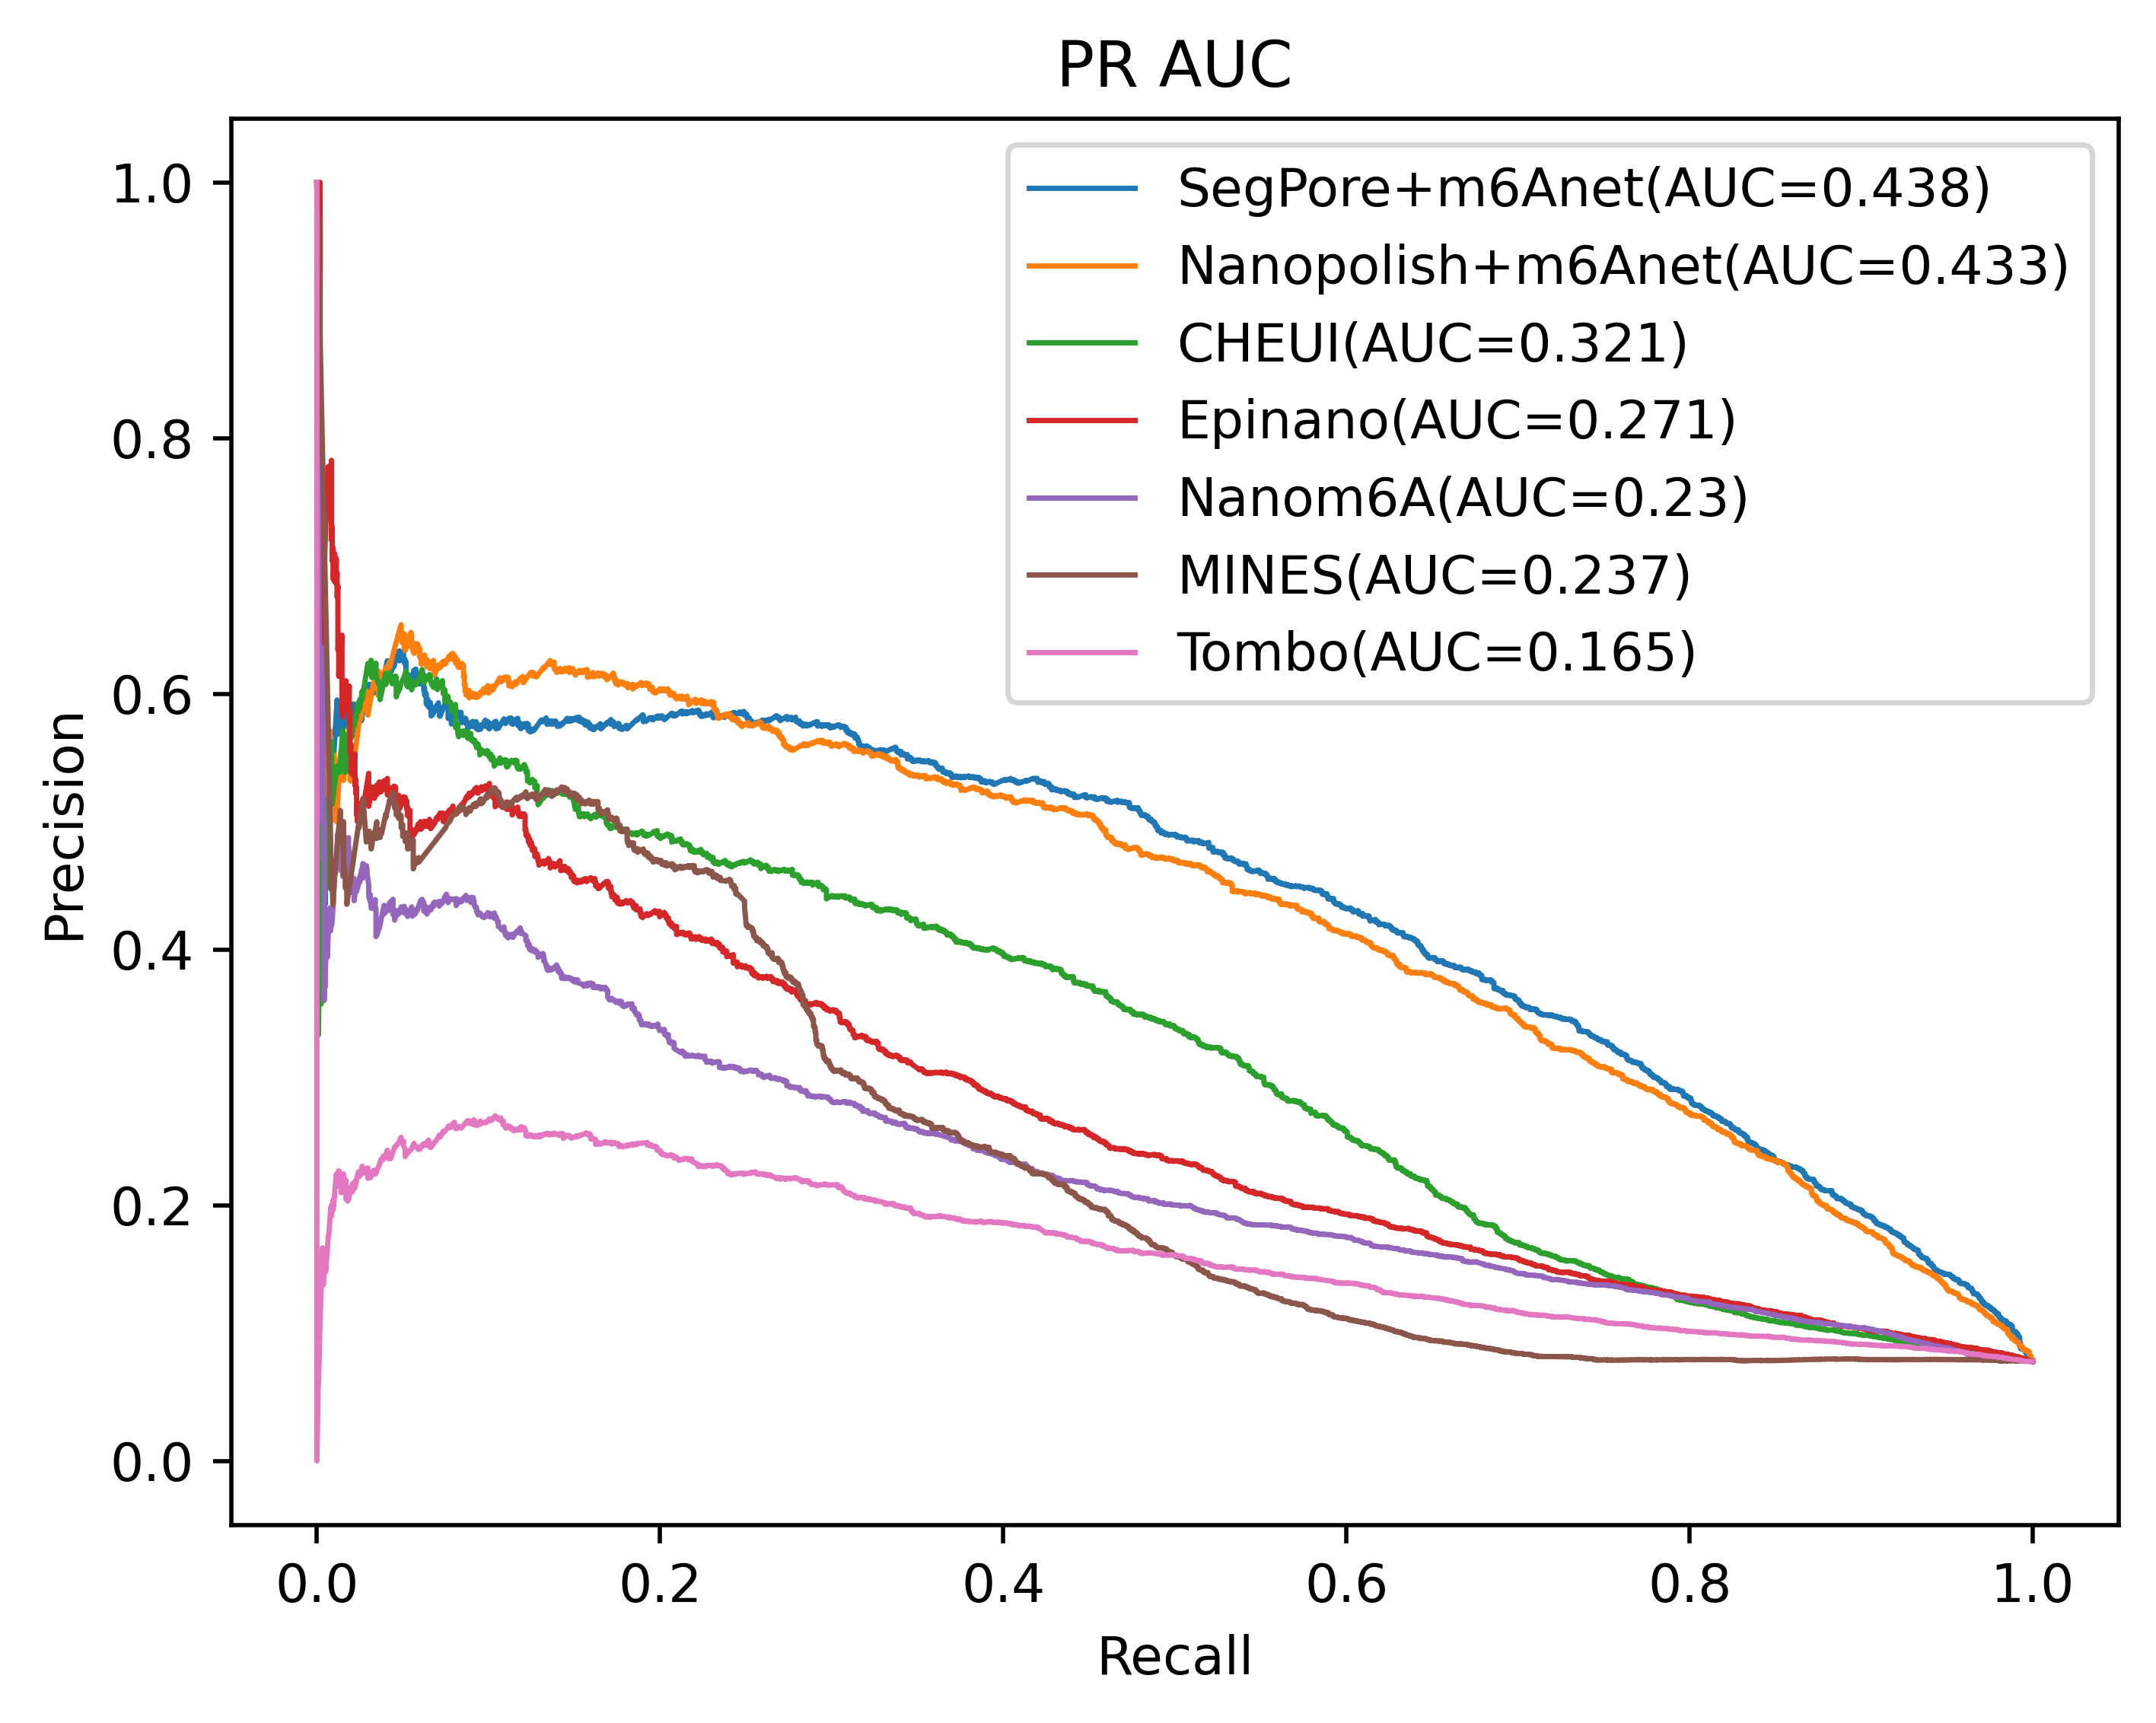

In [3]:
all_model_df = pd.read_csv("site_mod_rate_mES_WT_all_motif_with_cheui.csv")
plot_roc_auc(all_model_df, "all", "roc_all_v2.jpg")
plot_pr_auc(all_model_df, "all", "pr_all_v2.jpg")

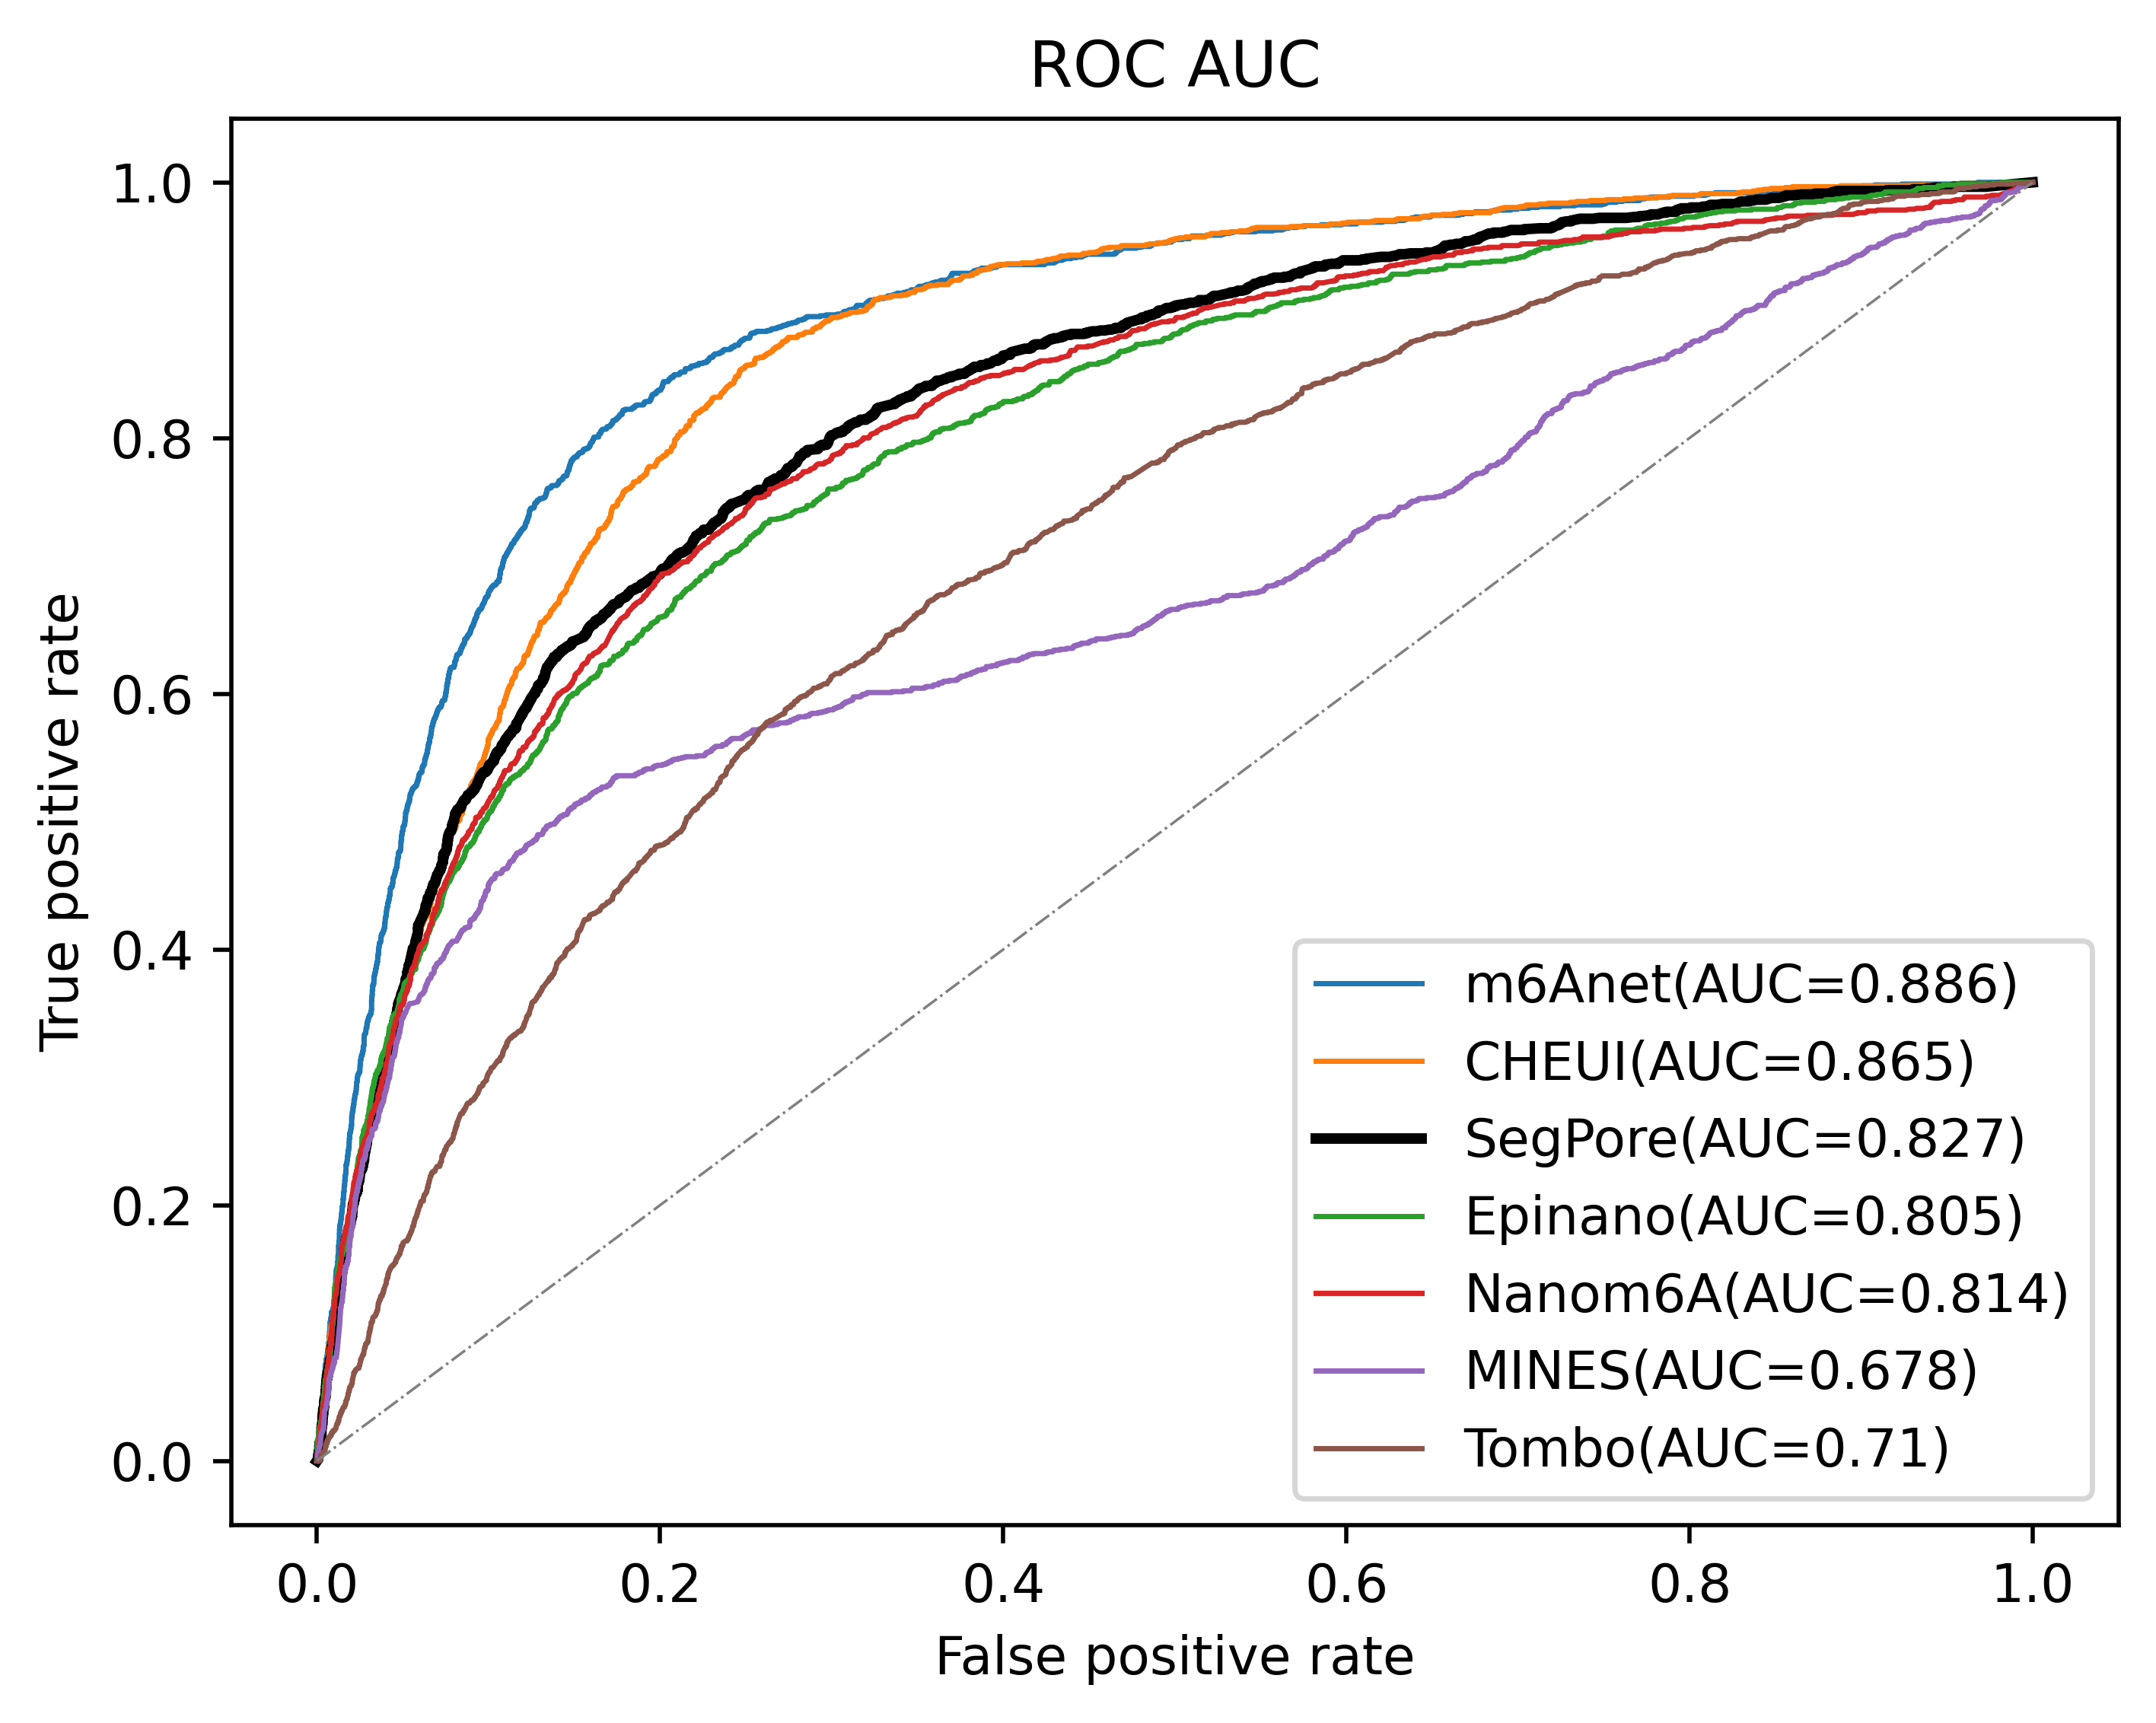

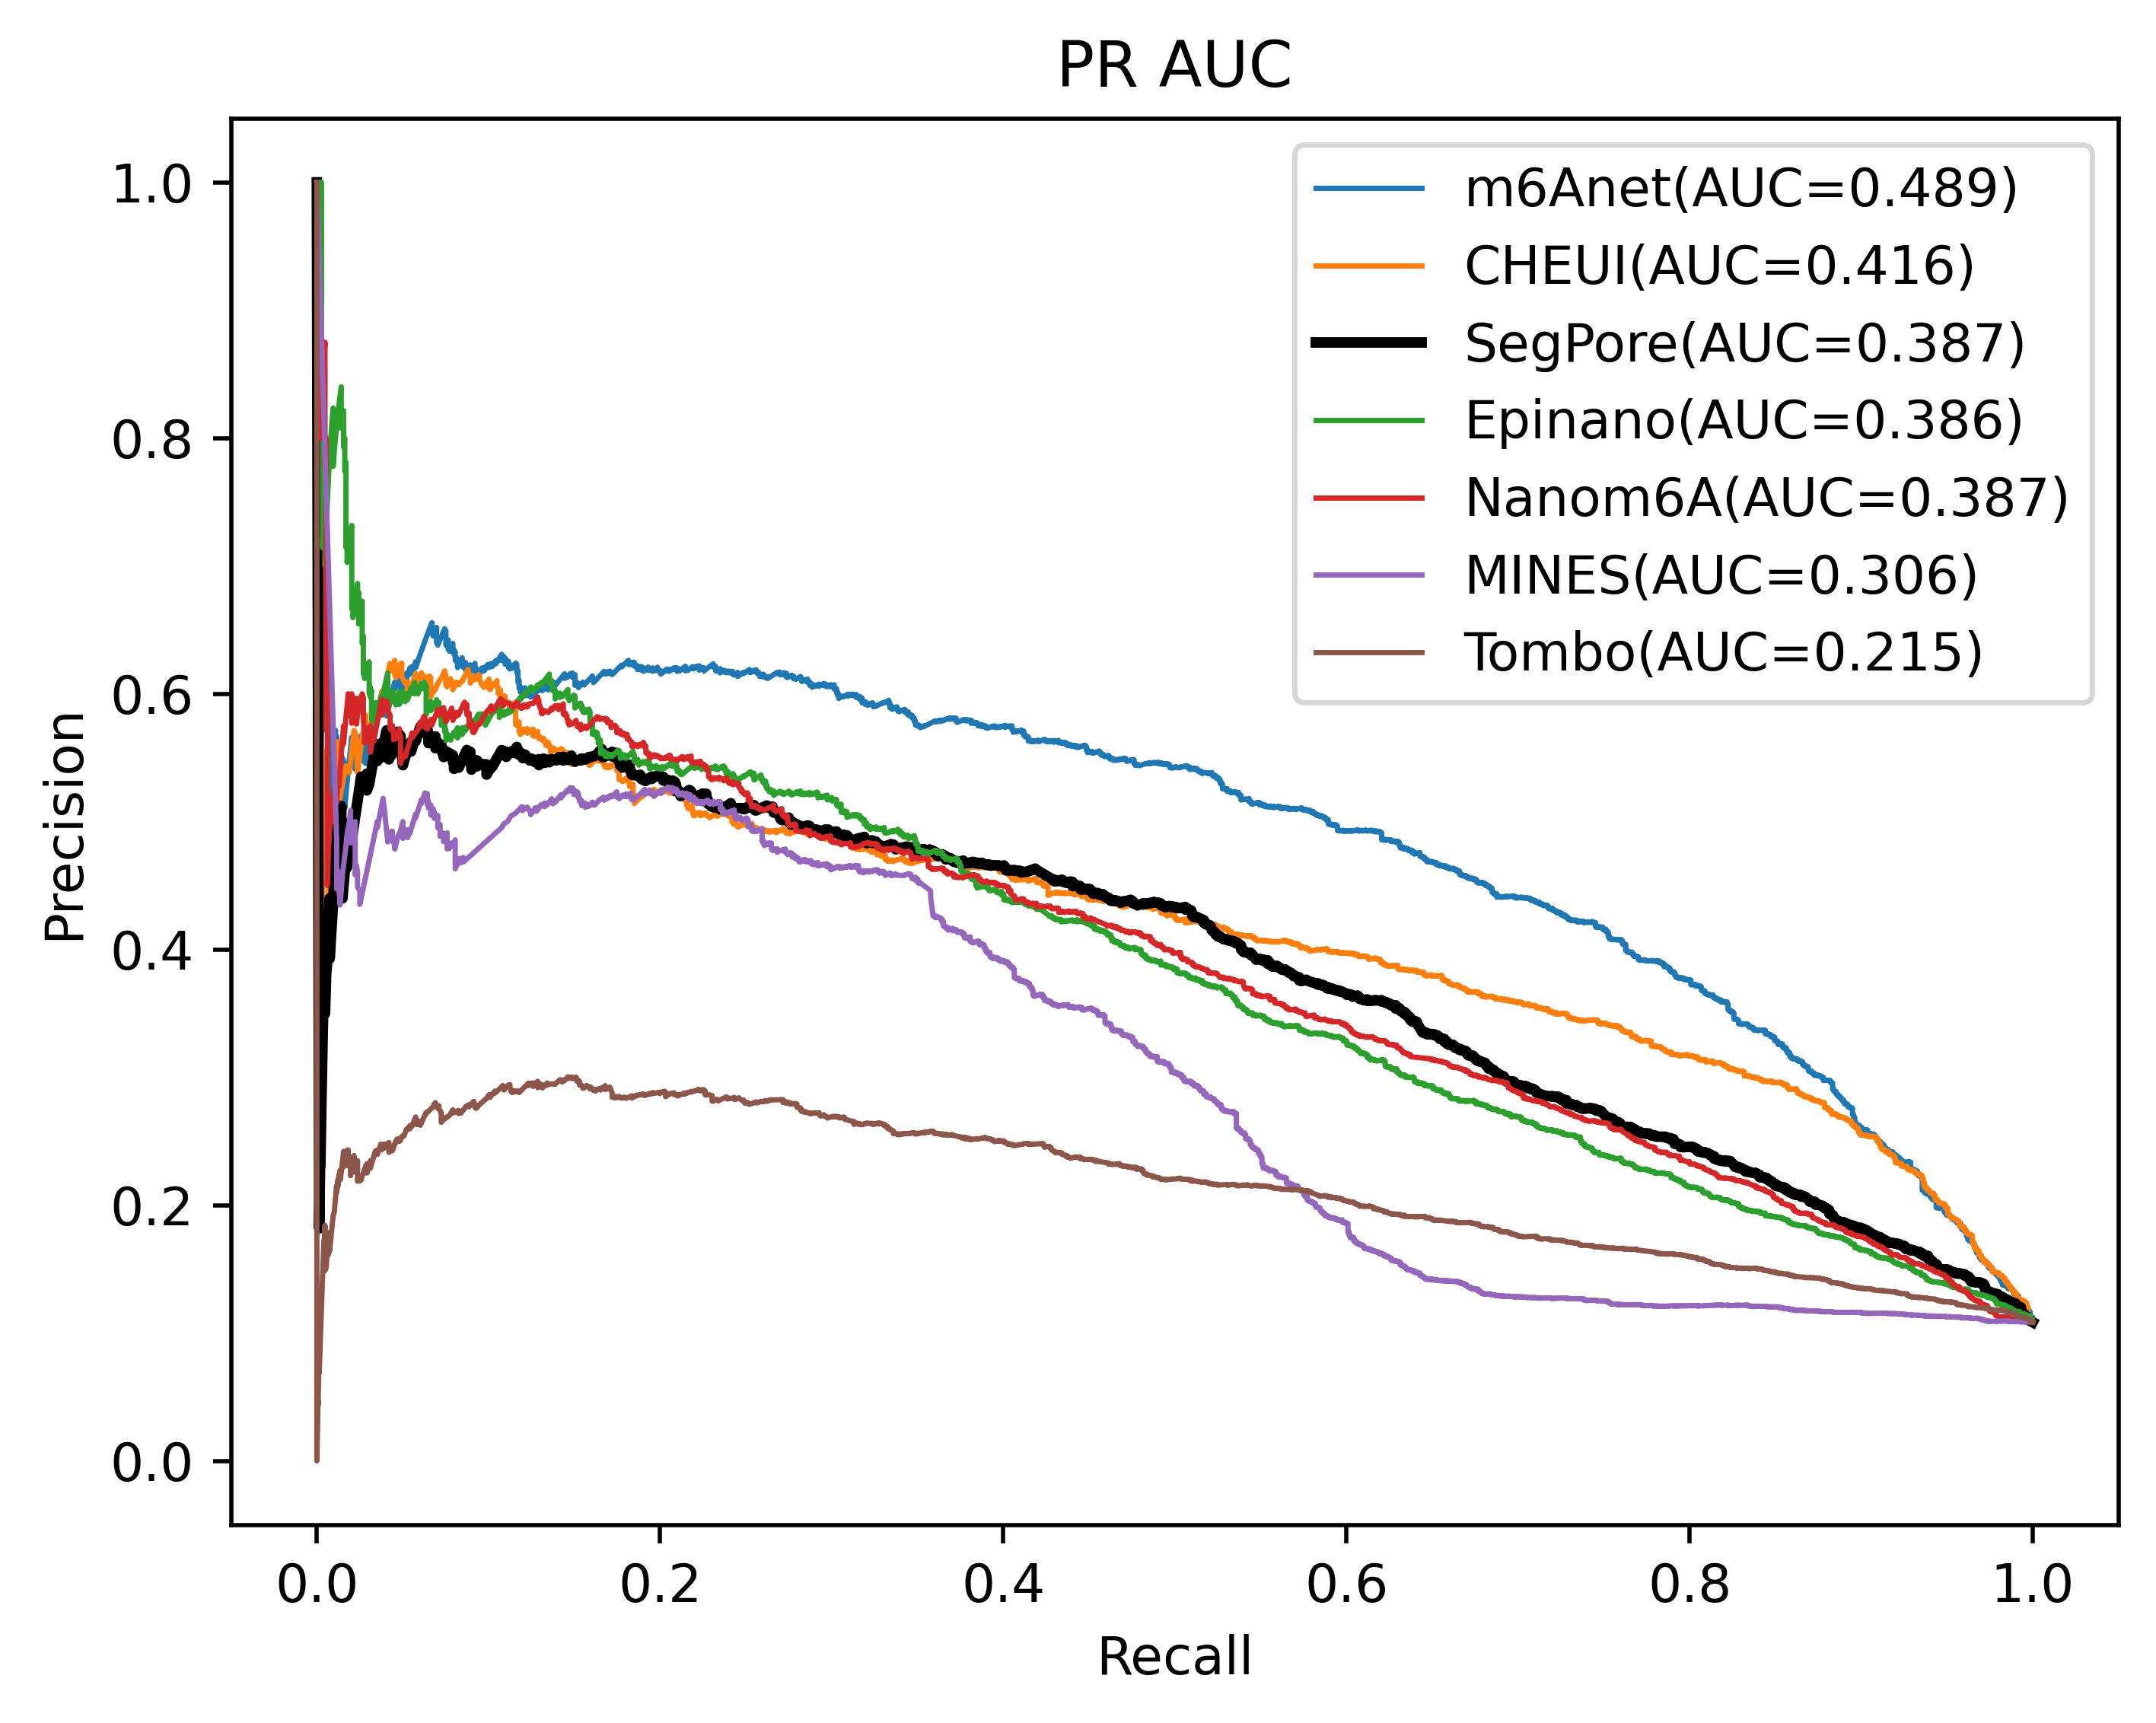

In [9]:
selected_model_df = pd.read_csv("site_mod_rate_mES_WT_selected_motif_with_cheui.csv")
plot_roc_auc(selected_model_df, "selected", "roc_select_v2.jpg")
plot_pr_auc(selected_model_df, "selected", "pr_select_v2.jpg")

In [7]:
selected_gene_df = pd.read_csv("ENSMUSG00000003153.10.info.csv")
gene_id = selected_gene_df.loc[0, "gene_id"]
modify_pos_num = selected_gene_df.loc[0, "modify_pos_num"]
pos_list = selected_gene_df.loc[0, "genes_pos_list"]
kmer_list = selected_gene_df.loc[0, "kmer_list"]

pos_list = pos_list[1:-1].split(",")
pos_arr = [int(i) for i in pos_list]

kmer_list = kmer_list[1:-1].split(",")
kmer_arr = [_kmer.strip()[1:-1] for _kmer in kmer_list]

kmer_pos_arr = []
for i, j in zip(kmer_arr, pos_arr):
    kmer_pos_arr.append(i + "_" + str(j+1))
print(kmer_pos_arr)

['GGACC_122728162', 'GGACA_122729638', 'AGACC_122729713', 'GGACT_122729848', 'AGACC_122729869', 'AGACC_122729948', 'GGACA_122730034', 'GGACT_122730044', 'AGACC_122730056', 'GGACT_122739856']


In [8]:
from sklearn.cluster import SpectralBiclustering
import seaborn as sns
import copy


def plot_mod_bar(bar_df):

    pal = sns.color_palette("Paired")
    cols = [pal[2] for _ in range(len(bar_df))]
    plt.figure(figsize=(12, 2), dpi=300)
    ax = sns.barplot(bar_df, x="key", y="rate", palette=cols)
    ax.bar_label(ax.containers[0], fontsize=19)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1.0, top=0.91, bottom=0)
    plt.show()
    

def plot_all_read_in_each_gene(con_df, gene_name, mod_pos_list):
    
    selected_cols = list(con_df.columns)

    mod_rate = []
    for col in selected_cols:
        _tmp_df = con_df[[col]]
        _tmp_mod = len(_tmp_df[_tmp_df[col] == 1])
        _sum_reads = len(_tmp_df[_tmp_df[col] == 0]) + len(_tmp_df[_tmp_df[col] == 1])
        mod_rate.append(np.round(_tmp_mod / _sum_reads, 2))

    read_num = con_df.shape[0]
    con_df = con_df.to_numpy()

    i = 6
    j = 3
    n_clusters = (i, j)
    model = SpectralBiclustering(n_clusters=n_clusters, method="log", random_state=0)

    data = copy.deepcopy(con_df)
    model.fit(data)

    re_column_labels = [1, 2, 3, 4, 5, 7, 8, 0, 6, 9]
    re_mod_pos_list = [mod_pos_list[i] for i in re_column_labels]
    re_mod_rate = []
    for l in re_column_labels:
        re_mod_rate.append(mod_rate[l])


    row_labels = model.row_labels_
    re_orders = [0, 5, 3, 2, 1, 4]
    re_row_labels = []
    for l in re_orders:
        for r in range(len(row_labels)):
            if row_labels[r] == l:
                re_row_labels.append(r)

    from collections import Counter
    row_lines = Counter(row_labels)
    y_line = [0]
    for i in re_orders:
        y_line.append(y_line[-1] + row_lines[i])
    y_line.append(len(row_labels))

    # Reordering first the rows and then the columns.
    reordered_rows = data[re_row_labels]
    reordered_data = reordered_rows[:, re_column_labels]


    reslected_cols = [0, 1, 2, 3, 5, 7, 8, 9]
    reordered_data = reordered_data[:, reslected_cols]

    select_mod_pos_list = []
    for i in reslected_cols:
        select_mod_pos_list.append(re_mod_pos_list[i])

    selected_mod_rate = []
    for i in reslected_cols:
        selected_mod_rate.append(re_mod_rate[i])

    bar_df = pd.DataFrame(list(zip(np.arange(len(selected_mod_rate)), selected_mod_rate)), columns=['key', 'rate'])
#     plot_mod_bar(bar_df)

    plt.figure(figsize=(10, 15), dpi=600) 
    lw = 2.0
    y_line[0] = y_line[0] + 0.5
    y_line[-1] = y_line[-1] - 1
    for x in [0.015, 6, 7, 8 - 0.02]:
        plt.axvline(x=x, color="black", linewidth=lw)
    for y in y_line:
        plt.axhline(y=y, color="black", linewidth=lw)

    myColors = ((0.6330638645080214, 0.7536095256664136, 0.9243691185566065), # missing
                (0.9490196078431372, 0.9490196078431372, 0.9490196078431372),
                (0.984313725490196, 0.6039215686274509, 0.6) )
    
    from matplotlib.colors import LinearSegmentedColormap
    my_camp = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    ax = sns.heatmap(reordered_data, annot=False, cmap=my_camp, xticklabels=True, yticklabels=False)

    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    colorbar.set_ticklabels(['Unmapped\n(Missing value)', 'Unmodified', 'Modified'], fontsize=14)

    plt.xticks(np.arange(len(select_mod_pos_list)) + 0.5, select_mod_pos_list, rotation=90, fontsize=12)
    plt.subplots_adjust(left=0.01, right=0.91, top=0.99, bottom=0.13)
    plt.show()
    
    return bar_df

In [9]:
gene_df = pd.read_csv("ENSMUSG00000003153.10.reads.csv")
bar_df = plot_all_read_in_each_gene(gene_df, gene_id, kmer_pos_arr)

In [10]:
print(bar_df)

   key  rate
0    0  0.18
1    1  0.23
2    2  0.95
3    3  0.11
4    4  0.68
5    5  0.36
6    6  0.45
7    7  0.27


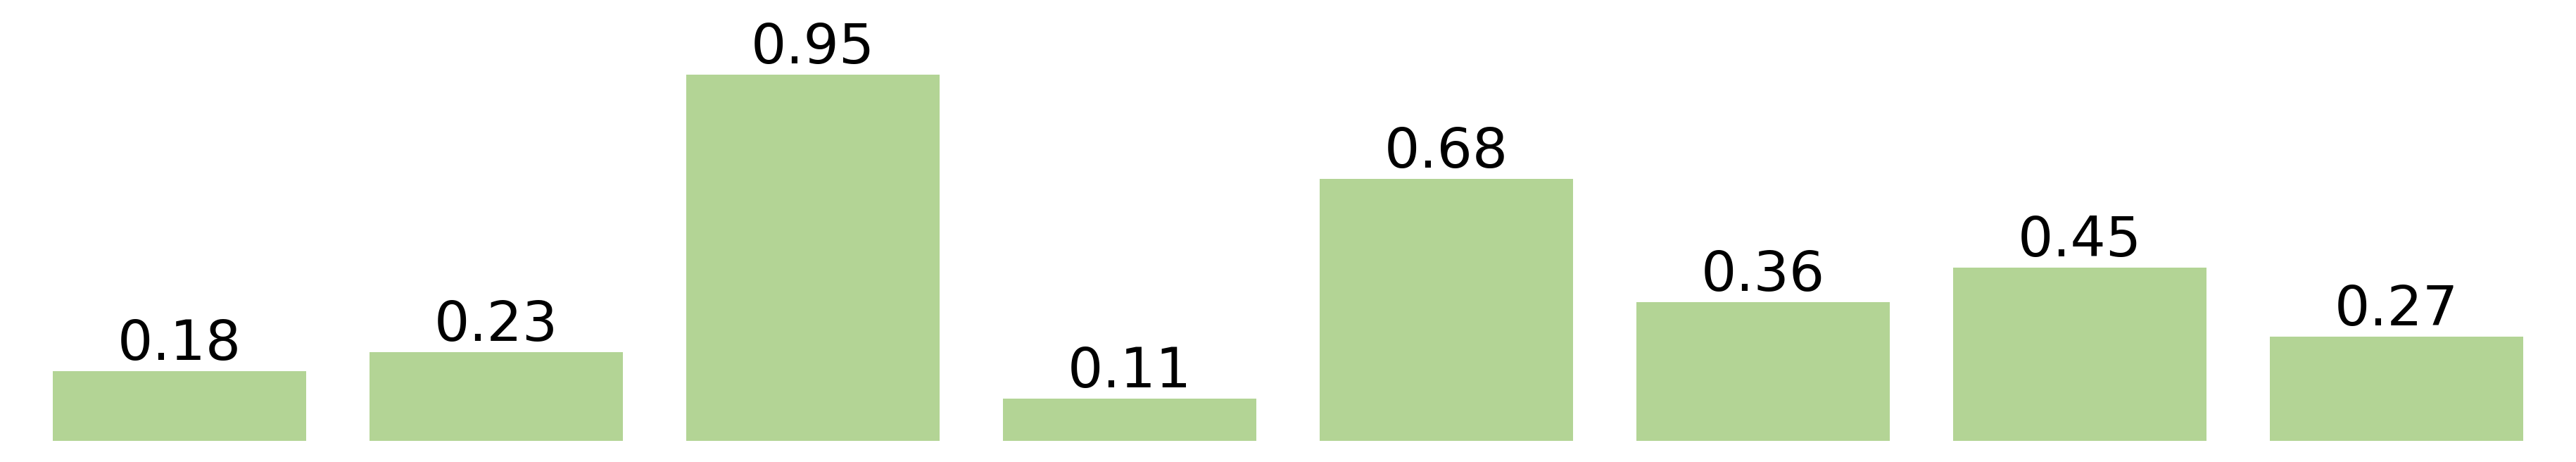

In [11]:
plot_mod_bar(bar_df)